In [7]:
import numpy as np
from scipy import signal
from scipy.signal import butter, lfilter, iirnotch
import matplotlib.pyplot as plt

In [18]:
data = [signal.rstrip('\n') for signal in open('DataN.txt')]
signals = []
for signal in data:
    signals.append(float(signal))
    
time_axis = np.linspace(0,4*len(signals), len(signals));

In [3]:
def notch_filter(noisy_signals, sampling_rate, dc_component, quality_factor: int = 30):
    
    b, a = iirnotch(dc_component, quality_factor, sampling_rate)
    noise_free_signals = lfilter(b, a, noisy_signals)
    
    return noise_free_signals

In [4]:
def butter_bandpass_filter(noisy_signals, lowcut, highcut, sampling_rate, order: int = 5):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    noise_free_signals = lfilter(b, a, noisy_signals)
    return noise_free_signals

In [16]:
def derivatise(signals):
    filterd_signals= np.zeros((len(signals)))
    filterd_signals[0:2] = signals[0:2]

    T = 1/256
    for s in range(2,len(signals)-2):
        op = -2*(signals[s-1])
        op -= ((signals[s-2]))
        op += (signals[s+2])
        op += (2*(signals[s+1]))
        op *= (1/(8*T))
        filterd_signals[s] += op
    
    return filterd_signals

In [17]:
def square(differentiated_signals):
    squared_signals = []
    for signal in differentiated_signals:
        squared_signals.append(np.square(signal))
    return squared_signals     

In [69]:
def smoothen(squared_signals, window_size):
    smoothed_signals = np.zeros((len(squared_signals)))
    smoothed_signals[0:window_size] = squared_signals[0:window_size]
    starting_index = window_size-1
    for signal in range(starting_index, len(squared_signals)):
        for index in range(0, window_size):
            smoothed_signals[signal] += (squared_signals[signal-index])
        smoothed_signals[signal] /= window_size
    return smoothed_signals

In [609]:
def set_threshold(signals, N: int=50):
    start=0
    end=N
    t=0
    maximas = []
    thres =0
    
    
    for i in range(0, len(signals),N):
        maximas.extend(max([signals[start:end]]))
        start+=1
        end+=1
    start=0
    end = N
    for i in range(0, len(maximas),N):
        thres+= max(maximas[start:end])
        start+=1
        end += 1
    thres/= len(maximas)
        
        
    return thres  
        

In [240]:
def RR_indices(signals, T):
    interval_index = []
    for signal in range(0, len(signals)):
        if(signals[signal]>T):
            interval_index.append(signal)
            
    return interval_index

In [352]:
def R_peaks_indices(signals, T):
    R_index = []
    ascend = 0
  
    for signal in range(0, len(signals)):
        
        if(signals[signal]> T ):
            ascend = signals[signal]
            skipped_signals, R_wave = helper_detect_ascending_peak(signals, signal)
            R_index.append(R_wave)
            new_index = helper_detect_descending_peak(signals, skipped_signals, ascend)
            signal += (new_index +1)
    return R_index

In [117]:
def RR_intervals(signals, RR_indexes):
    RR_intervals = []

    for index in range(0,len(RR_indexes)-1):
        R= RR_indexes[index]
        RR = RR_indexes[index+1]
        RR_intervals.extend(signals[R:RR])
    return RR_intervals

In [213]:
def RR_timestamps(time_axis, RR_indexes):
    
    RR_timestamps = []
    for index in range(0,len(RR_indexes)-1):
        t= RR_indexes[index]
        tt = RR_indexes[index+1]
        RR_timestamps.extend(time_axis[t:tt])
    RR_timestamps.append(time_axis[len(RR_indexes)-1])   
    return RR_timestamps
    

In [496]:
def R_timestamps(time_axis, R_index):
    R_timestamps = []
    for index in R_index:
        R_timestamps.append(time_axis[index])
    return R_timestamps

# Deliverables

## Signals After Filtering

In [5]:
sample_rate =256
frequency_to_remove = 50
low_cut_frequncy = 0.1
high_cut_frequncy = 45
window_size_5 = 5
window_size_15 = 15
window_size_25 = 25

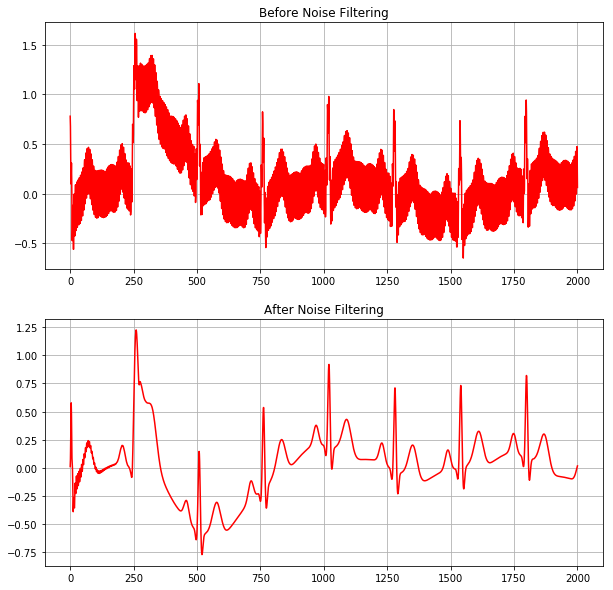

In [63]:
time_axis = np.linspace(0,2000, 2000);

dc_component_removed = notch_filter(signals, sample_rate, frequency_to_remove)
noise_free_signals = butter_bandpass_filter(dc_component_removed, low_cut_frequncy, high_cut_frequncy, sample_rate)

figure, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].grid()
ax[0].plot(time_axis, signals[0:2000], color='red')
ax[0].title.set_text('Before Noise Filtering')

ax[1].plot(time_axis, noise_free_signals[0:2000], color='red')
ax[1].grid()
ax[1].title.set_text('After Noise Filtering')

## ECG Signals With Different WIndow Sizes

In [19]:
dc_component_removed = notch_filter(signals, sample_rate, frequency_to_remove)
noise_free_signals = butter_bandpass_filter(dc_component_removed, low_cut_frequncy, high_cut_frequncy, sample_rate)

differentiated_signals = derivatise(noise_free_signals)
squared_signals = square(differentiated_signals)

In [30]:
smoothed_signals_N5 = smoothen(squared_signals,window_size_5)
samples_N5 = smoothed_signals_N5[0:2000]

smoothed_signals_N15 = smoothen(squared_signals,window_size_15)
samples_N15 = smoothed_signals_N15[0:2000]

smoothed_signals_N25 = smoothen(squared_signals,window_size_25)
samples_N25 = smoothed_signals_N25[0:2000]

In [610]:
# threshold_N5 = set_threshold(smoothed_signals_N5, window_size_5)
# threshold_N15 = set_threshold(smoothed_signals_N15, window_size_15)
threshold_N25 = set_threshold(smoothed_signals_N25)

In [614]:
# R_N5_indices = R_peaks_indices(smoothed_signals_N5, threshold_N5)[0:2000]
# R_N15_indices = R_peaks_indices(smoothed_signals_N15, threshold_N15)[0:2000]
#R_N25_indices = R_peaks_indices(smoothed_signals_N25, threshold_N25)[0:2000]


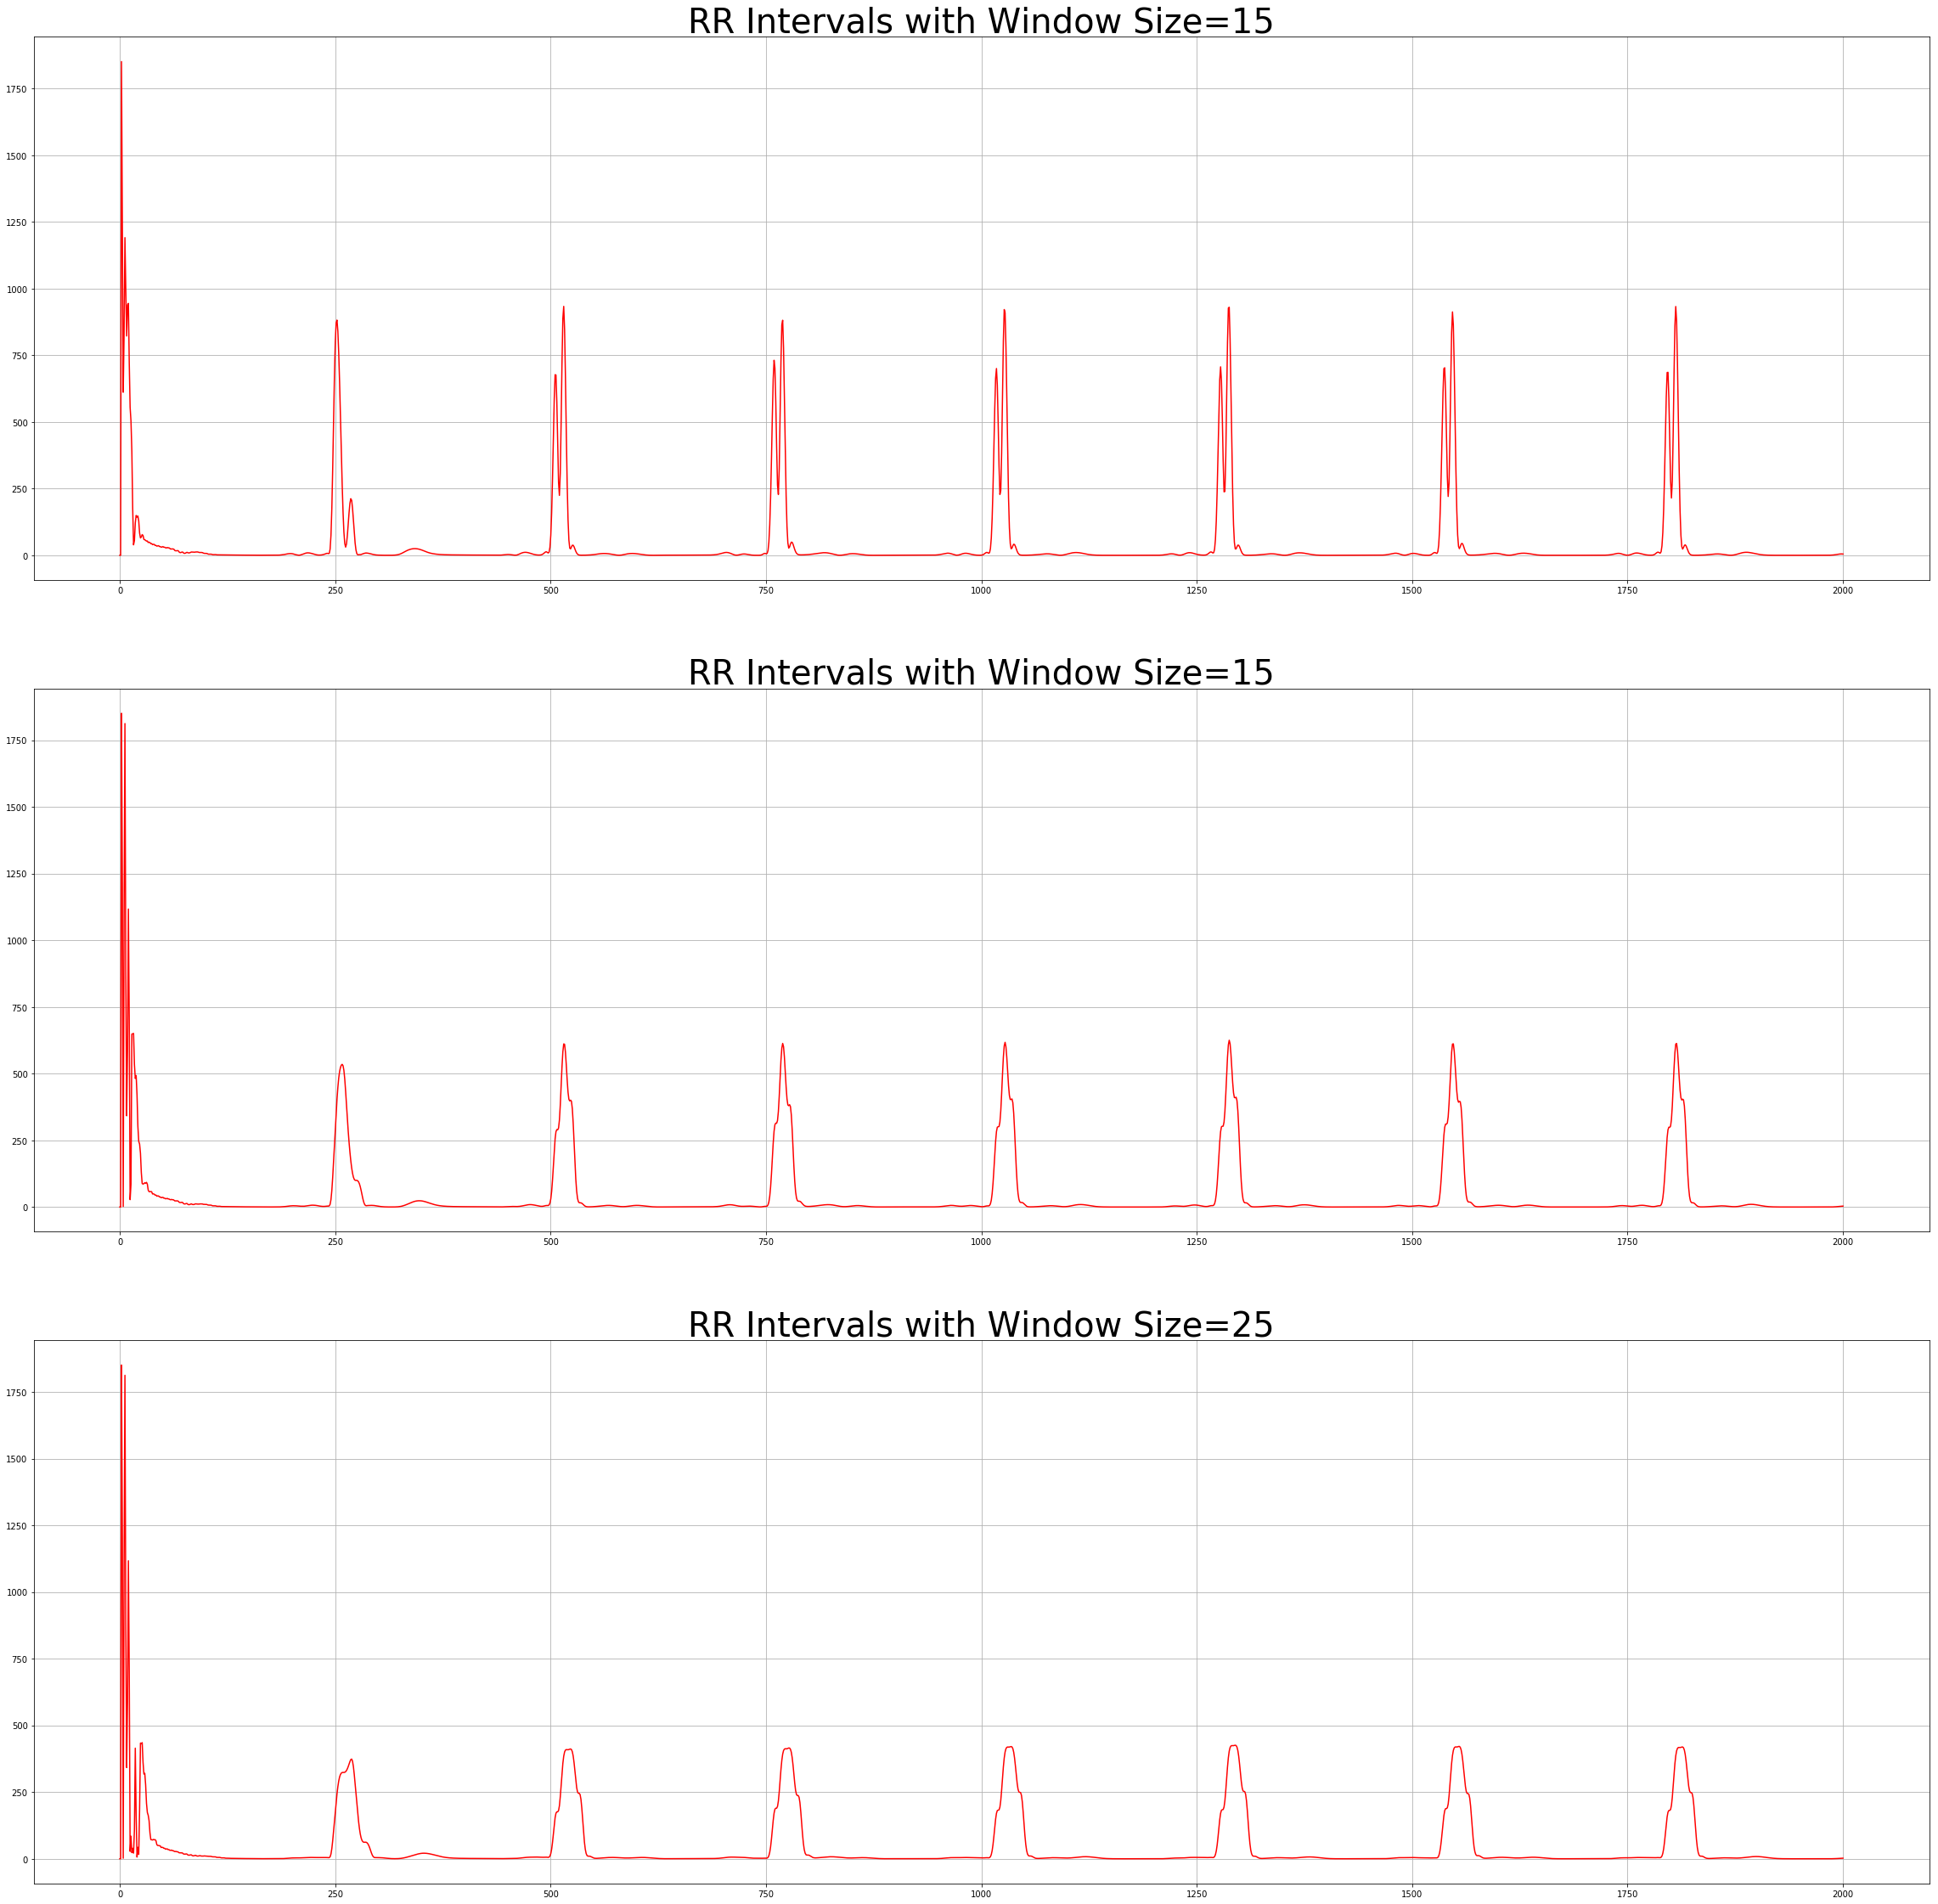

In [68]:
RR_figure, RR_ax = plt.subplots(3,1,figsize=(40, 40))
time = time_axis[0:2000]

s= int(max(smoothed_signals_N5[0:2000])/2)

RR_ax[0].plot(time,smoothed_signals_N5[0:2000], color='red')
RR_ax[0].set_title('RR Intervals with Window Size=15', fontsize= 40)
RR_ax[0].grid()
# for i, v in enumerate(smoothed_signals_N5[0:2000]):
#         if v in s:
#             plt.text(time[i]-0.4, v+0.01, '********')


RR_ax[1].plot(time, smoothed_signals_N15[0:2000], color='red')
RR_ax[1].set_title('RR Intervals with Window Size=15', fontsize= 40)
RR_ax[1].grid()


RR_ax[2].plot(time, smoothed_signals_N25[0:2000], color='red')
RR_ax[2].set_title('RR Intervals with Window Size=25', fontsize= 40)
RR_ax[2].grid()

plt.show()

## What can you conclude about the optimal setting of N?

### Increasing the window size decreased the abrupt changes in the signals. By comparing the output signal of window size 5, 15 and 25, using 25 for a window size gave the smoothest signals and the peak became more aligned with the supposed position of the R wave.

## ECG Signals With Different WIndow Sizes, Without Noise Filtering

In [ ]:
differentiated_signals_2 = derivatise(noise_free_signals)
squared_signals_2 = square(differentiated_signals)
smoothed_signals_N5 = smoothen(squared_signals,window_size_5)
samples_N5 = smoothed_signals_N5[0:2000]

smoothed_signals_N15 = smoothen(squared_signals,window_size_15)
samples_N15 = smoothed_signals_N15[0:2000]

smoothed_signals_N25 = smoothen(squared_signals,window_size_25)
samples_N25 = smoothed_signals_N25[0:2000]